In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
rng = np.random.default_rng(1337)

idx = pd.period_range(datetime(2022, 1, 1), datetime(2022, 12, 31), freq="D")
innovation_magnitude = 0.05

x0 = rng.normal(size=(6, 1))
shocks = rng.normal(scale=innovation_magnitude, size=(len(idx), 1, 1))

# Generate Data

## Loop Method

In [3]:
res = []
rng = np.random.default_rng(1337)
last_six_days = x0.ravel().copy()
for i, date in enumerate(idx):
    next_day = -np.sum(last_six_days) + shocks[i, 0, 0]

    res.append({"date": date, "value": next_day})

    # I shift days left to right instead of right to left to match what a lag
    # matrix will do
    last_six_days = np.concatenate([np.array([next_day]), last_six_days[:-1]])
df = pd.DataFrame(res)
df["day_of_week"] = df.date.dt.dayofweek

## Statespace Representation

In [4]:
T = np.array([[-1, -1, -1, -1, -1, -1]])
T = np.r_[T, np.eye(N=5, M=6)]

R = np.array([[1, 0, 0, 0, 0, 0]]).T

data = np.zeros((len(idx) + 1, 6, 1))
data[0] = x0

for t in range(1, data.shape[0]):
    data[t] = T @ data[t - 1] + R @ shocks[t - 1]

# discard x0
data = data[1:]

The only important thing to get right is the transition matrix, which sets the current state as the (negative) sum of the last 6 values, and carries along 5 lags.

In [5]:
T

array([[-1., -1., -1., -1., -1., -1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.]])

### Equivalence

In [6]:
np.allclose(data[:, 0, 0], df.value.values)

True

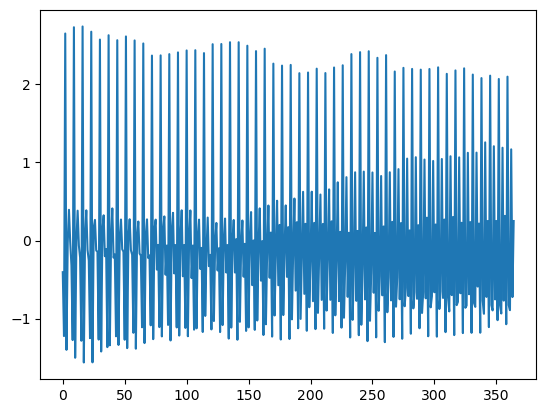

In [7]:
plt.plot(data[:, 0, 0])

# PyMC Statespace

In [8]:
from pymc_experimental.statespace.core.statespace import PyMCStateSpace
from pymc_experimental.statespace.utils.aesara_scipy import solve_discrete_lyapunov
import pytensor.tensor as at
import pymc as pm


class SeasonalRandomWalk(PyMCStateSpace):
    def __init__(
        self,
        data,
        n_lags: int = 6,
        stationary_initialization: bool = True,
        filter_type: str = "standard",
    ):

        self.stationary_initialization = stationary_initialization

        k_states = n_lags
        k_posdef = 1

        super().__init__(data, k_states, k_posdef, filter_type)

        # Initialize the matrices
        self.ssm["design"] = np.r_[[1.0], np.zeros(k_states - 1)][None]

        self.ssm["transition"] = np.r_[
            np.full((1, k_states), -1), np.eye(N=k_states - 1, M=k_states)
        ]

        self.ssm["selection"] = np.r_[[[1.0]], np.zeros(k_states - 1)[:, None]]

        self.ssm["initial_state"] = np.zeros(k_states)[:, None]

        self.ssm["initial_state_cov"] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ("state_cov",) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        """
        These will be used to find the required parameters from the PyMC model, so
        the names of the priors in the PyMC model will have to match.
        """
        names = ["x0", "P0", "state_sigma2"]
        if self.stationary_initialization:
            names.remove("P0")

        return names

    def update(self, theta: at.TensorVariable) -> None:
        """
        Put parameter values from vector theta into the correct positions in the state space matrices.

        Parameters
        ----------
        theta: TensorVariable
            Vector of all variables in the state space model
        """
        cursor = 0

        param_slice = slice(cursor, cursor + self.k_states)
        cursor += self.k_states
        self.ssm["initial_state"] = theta[param_slice].reshape((-1, 1, 1))

        if not self.stationary_initialization:
            # initial covariance
            param_slice = slice(cursor, cursor + self.k_states**2)
            cursor += self.k_states**2
            self.ssm["initial_state_cov", :, :] = theta[param_slice].reshape(
                (self.k_states, self.k_states)
            )

        # State covariance
        param_slice = slice(cursor, cursor + 1)
        cursor += 1
        self.ssm[self._state_cov_idx] = theta[param_slice]

        if self.stationary_initialization:
            # Solve for matrix quadratic for P0
            T = self.ssm["transition"]
            R = self.ssm["selection"]
            Q = self.ssm["state_cov"]

            P0 = solve_discrete_lyapunov(T, at.linalg.matrix_dot(R, Q, R.T), method="direct")
            self.ssm["initial_state_cov", :, :] = P0

In [9]:
coords = {
    "states": ["data", "L1.data", "L2.data", "L3.data", "L4.data", "L5.data"],
    "random_states": ["data"],
}

model = SeasonalRandomWalk(df.value.values[:, None], stationary_initialization=False)

with pm.Model(coords=coords) as daily_seasonal_grw:
    x0 = pm.Normal("x0", mu=0.0, sigma=1.0, dims=["states"])

    # Variance of 1 is plenty diffuse for this model. Had trouble with solve_lyapunov, diagonal cov too slow.
    P0 = pm.Deterministic("P0", at.eye(6))
    state_sigmas = pm.HalfNormal("state_sigma2", sigma=1.0, dims=["random_states"])

    model.build_statespace_graph()

In [10]:
daily_seasonal_grw

In [11]:
with daily_seasonal_grw:
    idata = pm.sample(init="jitter+adapt_diag_grad", target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x0, state_sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 690 seconds.


/Users/jessegrabowski/mambaforge/envs/pymc/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


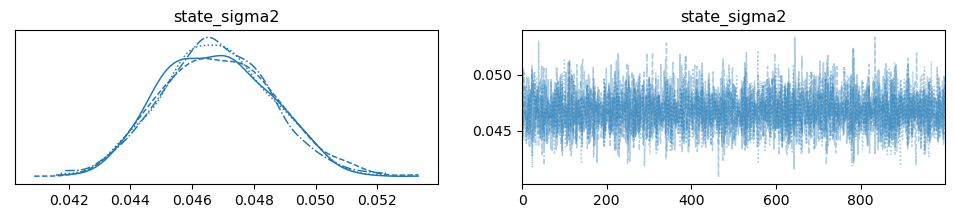

In [13]:
import arviz as az

az.plot_trace(idata, var_names=["state_sigma2"], transform=np.sqrt);

In [14]:
with daily_seasonal_grw:
    post_pred = model.sample_conditional_posterior(
        idata, filter_output="predicted", n_simulations=10
    )

## Forcasting

Iterate model dynamics forward with normal innovations to forecast, using the last data observation as the initial state

In [15]:
x0 = df.value.values[-6:]
T = model.ssm["transition"].eval()
R = model.ssm["selection"].eval()

n_simulations = 5000
H = 50

simulation = np.empty((n_simulations, H, 6, 1))
simulation[:, 0] = x0.reshape(1, 6, 1)
post = az.extract(idata, "posterior")

for i in range(n_simulations):
    idx = np.random.choice(post.state_sigma2.shape[0])
    sigma = post.state_sigma2.values[:, idx]
    for h in range(1, H):
        simulation[i, h] = T @ simulation[i, h - 1] + R @ np.random.normal(
            scale=np.sqrt(sigma), size=(1, 1)
        )

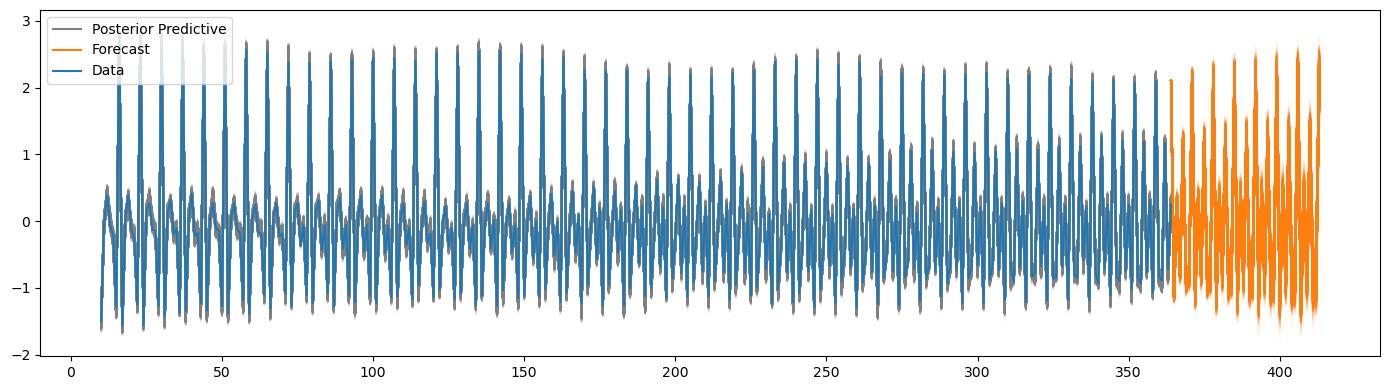

In [23]:
fig, ax = plt.subplots(figsize=(14, 4))

# Omit first 10 observations to cut the initial high variance out (could also use smoother)
ax.plot(
    df.index[10:],
    post_pred[0, 10:-1, 0],
    alpha=1,
    color="0.5",
    label="Posterior Predictive",
)
ax.plot(df.index[10:], post_pred[:, 10:-1, 0].T, alpha=0.1, color="0.5")

ax.plot(
    np.arange(df.index[-1], df.index[-1] + H),
    simulation[0, :, 0, 0],
    color="tab:orange",
    alpha=1,
    label="Forecast",
)
ax.plot(
    np.arange(df.index[-1], df.index[-1] + H),
    simulation[:, :, 0, 0].T,
    color="tab:orange",
    alpha=0.05,
)
df.value.iloc[10:].plot(ax=ax, label="Data")

fig.set_facecolor("w")
ax.legend(loc="upper left")
fig.tight_layout()
plt.show()